<a href="https://colab.research.google.com/github/GreenRamSilgen/Medical_IMG_Classifier/blob/master/Medical_IMG_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import and Get data from kaggle

In [0]:
import math, os, json
import numpy as np
from numpy.random import seed
seed(100)
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg
import keras
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import set_random_seed
set_random_seed(100)

os.environ['KAGGLE_USERNAME'] = "xxx"
os.environ['KAGGLE_KEY'] = "xxx"

In [0]:
#!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

In [0]:
#!unzip chest-xray-pneumonia.zip

In [0]:
#os.remove("chest-xray-pneumonia.zip")

In [0]:
train_dir = './chest_xray/train/'
valid_dir = './chest_xray/test/'
test_dir = './chest_xray/val/'

#Helpers for directory and displaying images

In [0]:
def search_dir(type="normal", num=6):
  counter=0

  for file in os.listdir(train_dir + type.upper()+ "/"):
      if counter == num:
          break

      if file.endswith(".jpeg"):
          print(file)

      counter += 1

def display_images(type="normal", num=6):
  counter=0
  fig = plt.figure(figsize=(10, 8))
  
  for file in os.listdir(train_dir + type.upper()):

      if file.endswith(".jpeg"):
          if counter == num:
              break
          img = mpimg.imread(train_dir + type.upper()+"/"+file)
          plt.subplot(231+counter)
          plt.title(file.split('.')[0])
          imgplot = plt.imshow(img)
          counter += 1

#Look at Normal and Pneumonia images

(making sure you actually got the images loaded properly)

In [0]:
search_dir(type="pneumonia", num=10)
search_dir(type="normal", num=10)

In [0]:
print("PNEUMONIA IMAGES")
display_images(type="pneumonia", num=6)

In [0]:
print("NORMAL IMAGES")
display_images(type="normal", num=6)

#Generate training and testing data.

In [34]:
batch_size=163

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        width_shift_range=0.1,
        height_shift_range=0.1)

train_generator = train_datagen.flow_from_directory(
        train_dir, 
        target_size=(150, 150), 
        batch_size=batch_size, 
        class_mode="categorical")

Found 5216 images belonging to 2 classes.


In [36]:
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
        valid_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode="categorical")

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=1,
        class_mode="categorical",
        shuffle=False)

Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


#Get the ipv3 model and train it on training data

In [39]:
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
predictions = keras.layers.Dense(2, activation='softmax')(x)


for layer in base_model.layers:
  layer.trainable = False  
  
final_model = keras.models.Model(inputs=base_model.inputs, outputs=predictions)









87916544/87910968 [==============================] - 7s 0us/step


In [47]:
final_model.compile(loss ="categorical_crossentropy", 
                    optimizer = "adam", 
                    metrics=["accuracy"])

fit_history = final_model.fit_generator(
        train_generator, #train data generator 
        steps_per_epoch=len(train_generator),
        epochs=20,
        validation_data=val_generator, #validation data generator 
        validation_steps=len(val_generator))

Epoch 1/20
32/32 [==============================] - 94s 3s/step - loss: 0.2376 - acc: 0.9074 - val_loss: 2.3143 - val_acc: 0.6683
Epoch 2/20
32/32 [==============================] - 88s 3s/step - loss: 0.2181 - acc: 0.9128 - val_loss: 2.6612 - val_acc: 0.6763
Epoch 3/20
32/32 [==============================] - 90s 3s/step - loss: 0.2168 - acc: 0.9116 - val_loss: 2.0612 - val_acc: 0.6106
Epoch 4/20
32/32 [==============================] - 89s 3s/step - loss: 0.2250 - acc: 0.9118 - val_loss: 3.6001 - val_acc: 0.6378
Epoch 5/20
32/32 [==============================] - 87s 3s/step - loss: 0.1965 - acc: 0.9204 - val_loss: 1.4387 - val_acc: 0.6522
Epoch 6/20
32/32 [==============================] - 90s 3s/step - loss: 0.2124 - acc: 0.9149 - val_loss: 1.4798 - val_acc: 0.6538
Epoch 7/20
32/32 [==============================] - 90s 3s/step - loss: 0.2001 - acc: 0.9216 - val_loss: 1.2097 - val_acc: 0.6715
Epoch 8/20
32/32 [==============================] - 90s 3s/step - loss: 0.2113 - acc: 0.91

In [55]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [56]:
filenames = test_generator.filenames
nb_samples = len(filenames)
predict = final_model.predict_generator(test_generator,steps = nb_samples).argmax(axis=-1)

print("PREDICTED LABELS:")
for idx, pred in enumerate(predict):
  if pred == 1:
    print(str(idx) + ". Pneumonia")
  else:
    print(str(idx) +". Normal")

PREDICTED LABELS:
0. Pneumonia
1. Normal
2. Normal
3. Normal
4. Pneumonia
5. Pneumonia
6. Pneumonia
7. Normal
8. Pneumonia
9. Pneumonia
10. Pneumonia
11. Pneumonia
12. Pneumonia
13. Pneumonia
14. Normal
15. Normal


In [57]:
#test_generator.classes
print("ACTUAL LABELS:")
for pred in test_generator.classes:
  if pred == 1:
    print(str(idx) +". Pneumonia")
  else:
    print(str(idx) +". Normal")

ACTUAL LABELS:
15. Normal
15. Normal
15. Normal
15. Normal
15. Normal
15. Normal
15. Normal
15. Normal
15. Pneumonia
15. Pneumonia
15. Pneumonia
15. Pneumonia
15. Pneumonia
15. Pneumonia
15. Pneumonia
15. Pneumonia


#Testing the model on two images from test set.

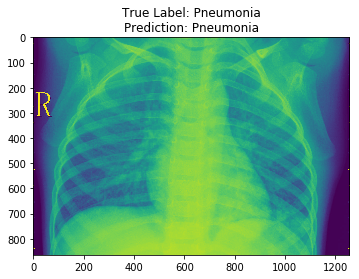

In [58]:
filename = "/content/chest_xray/val/PNEUMONIA/person1950_bacteria_4881.jpeg" 

img = image.load_img(filename, 
                     target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

y = final_model.predict(x)

predicton="Normal" if y.argmax(axis=-1)==0 else "Pneumonia"
actual="Normal" if "NORMAL" in filename else "Pneumonia" 

img=mpimg.imread(filename)
title_text = ("%s%s%s%s%s"%("True Label: ", actual, "\n", "Prediction: ", predicton))
plt.title(title_text)
imgplot=plt.imshow(img)

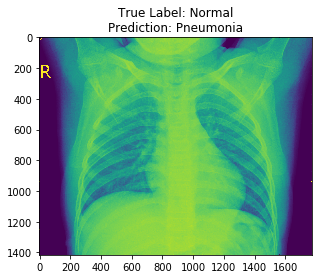

In [59]:
filename = "/content/chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg" 

img = image.load_img(filename, 
                     target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

y = final_model.predict(x)

predicton="Normal" if y.argmax(axis=-1)==0 else "Pneumonia"
actual="Normal" if "NORMAL" in filename else "Pneumonia" 

img=mpimg.imread(filename)
title_text = ("%s%s%s%s%s"%("True Label: ", actual, "\n", "Prediction: ", predicton))
plt.title(title_text)
imgplot=plt.imshow(img)